<a href="https://colab.research.google.com/github/aryamanpathak2022/cv_models/blob/main/model1/coins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [86]:
def detect_and_count_coins(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print("Error: Image not found!")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)

    # Edge Detection using Canny
    edges = cv2.Canny(blurred, 30, 180)

    # Find contours of the detected edges
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image
    detected_coins = image.copy()
    cv2.drawContours(detected_coins, contours, -1, (0, 255, 0), 2)

    # Count number of coins detected
    num_coins = len(contours)

    # Show results
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")

    ax[1].imshow(edges, cmap="gray")
    ax[1].set_title("Edge Detection")

    ax[2].imshow(cv2.cvtColor(detected_coins, cv2.COLOR_BGR2RGB))
    ax[2].set_title(f"Detected Coins: {num_coins}")

    plt.show()

    print(f"Total number of coins detected: {num_coins}")



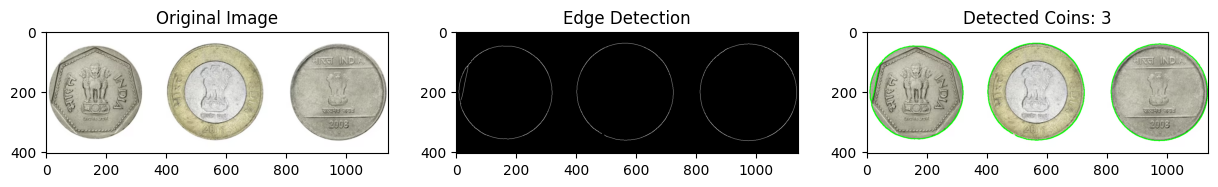

Total number of coins detected: 3


In [87]:
# Example usage
detect_and_count_coins("test10.png")

In [114]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

def segment_coins(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to smooth the image
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)

    # Apply Otsu's thresholding
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove small noise using morphological operations
    kernel = np.ones((7, 7), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (dilation)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Distance transform and thresholding for sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Label markers
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # Ensure background is not 0
    markers[unknown == 255] = 0  # Mark unknown regions as 0

    # Apply Watershed algorithm
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]  # Mark boundaries in red

    # Find contours to detect objects more accurately
    contours, _ = cv2.findContours(sure_fg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    fig, axes = plt.subplots(1, len(contours), figsize=(12, 4))
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        coin = image[y:y+h, x:x+w]
        axes[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
        axes[i].axis("off")
    plt.show()



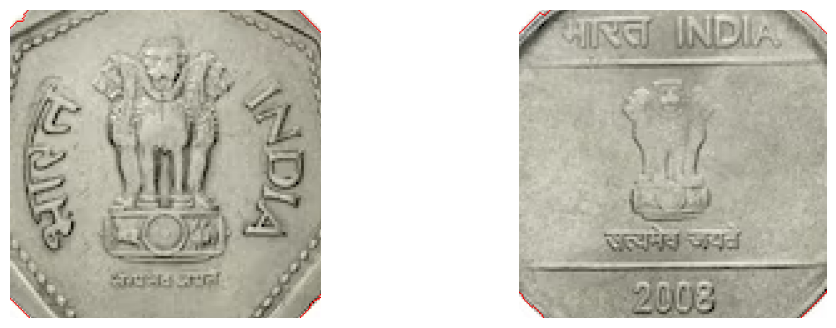

In [115]:
# Example usage
segment_coins("test10.png")

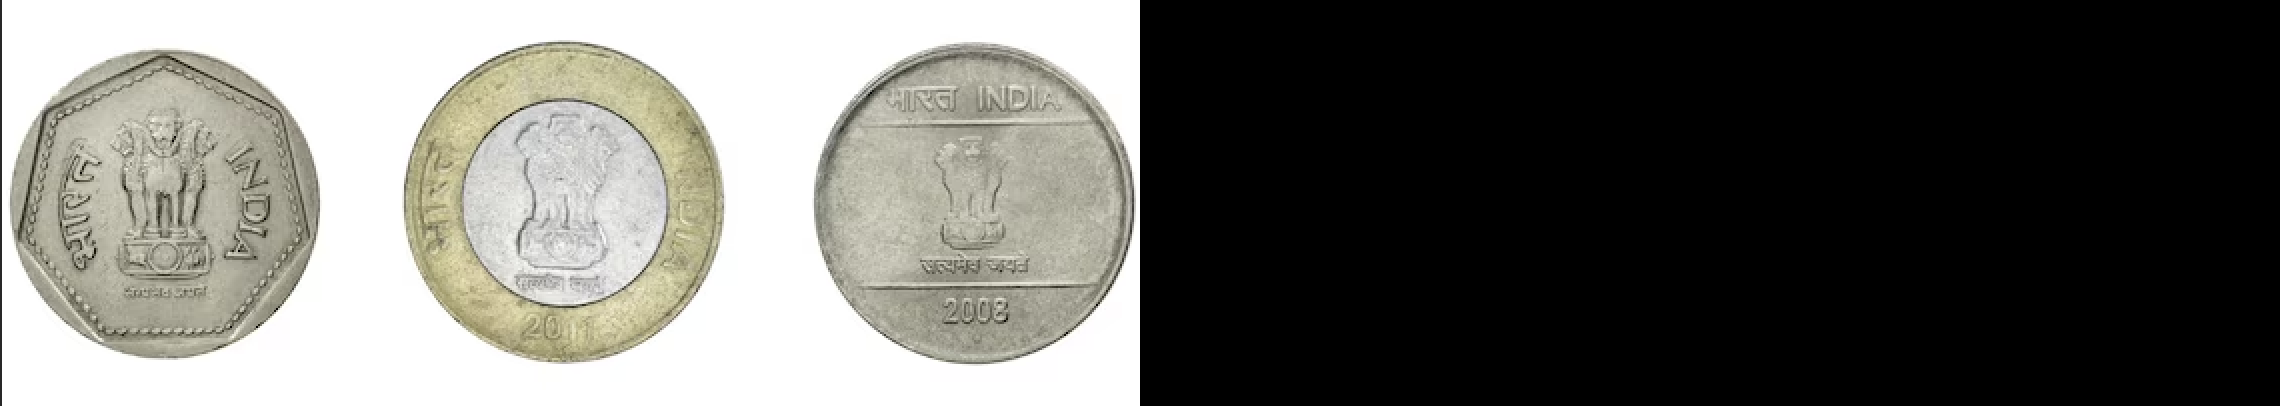

In [121]:
import cv2
import numpy as np
def detect_and_match_keypoints(img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    matcher = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict())
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        homography_matrix, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return homography_matrix
    else:
        return None

def stitch_images(img1, img2):
    H = detect_and_match_keypoints(img1, img2)
    if H is None:
        print("Not enough matches found!")
        return None

    width = img1.shape[1] + img2.shape[1]
    height = img1.shape[0]

    result = cv2.warpPerspective(img1, H, (width, height))
    result[0:img2.shape[0], 0:img2.shape[1]] = img2

    return result

# Load images
image1 = cv2.imread("test10.png")
image2 = cv2.imread("test10.png")

panorama = stitch_images(image1, image2)
if panorama is not None:
    cv2.imwrite("panorama.jpg", panorama)
    cv2_imshow(panorama)

In [118]:
from google.colab.patches import cv2_imshow